# DTFT Examples

### First, let's consider a first order AR filter

In [59]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as signal
import soundfile as sf

In [1]:
def H_AR1(v, alpha, normalize_gain=False):
    ## if normalize_gain==False, then this is b = [1], a=[1, -alpha]
    ## if normalize_gain==True, then this is b = [1 - |a|], a=[1, -alpha]
    H = 1 / ( 1 - alpha * np.exp( -2j * np.pi * v))
    if normalize_gain:
        H *= (1 - np.abs(alpha))
    return H

Let's plot this for various values of $\alpha$.  Set the `HPF` flag to use negative alpha values.  Set the `use_db` flag to plot the magnitude in dB.  Set the `normalize_gain` flag to set the passband gain to 1.

/Users/kmchugg/.pyenv/versions/ee301/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 7 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/kmchugg/.pyenv/versions/ee301/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 7 missing from current font.
  font.set_text(s, 0, flags=flags)


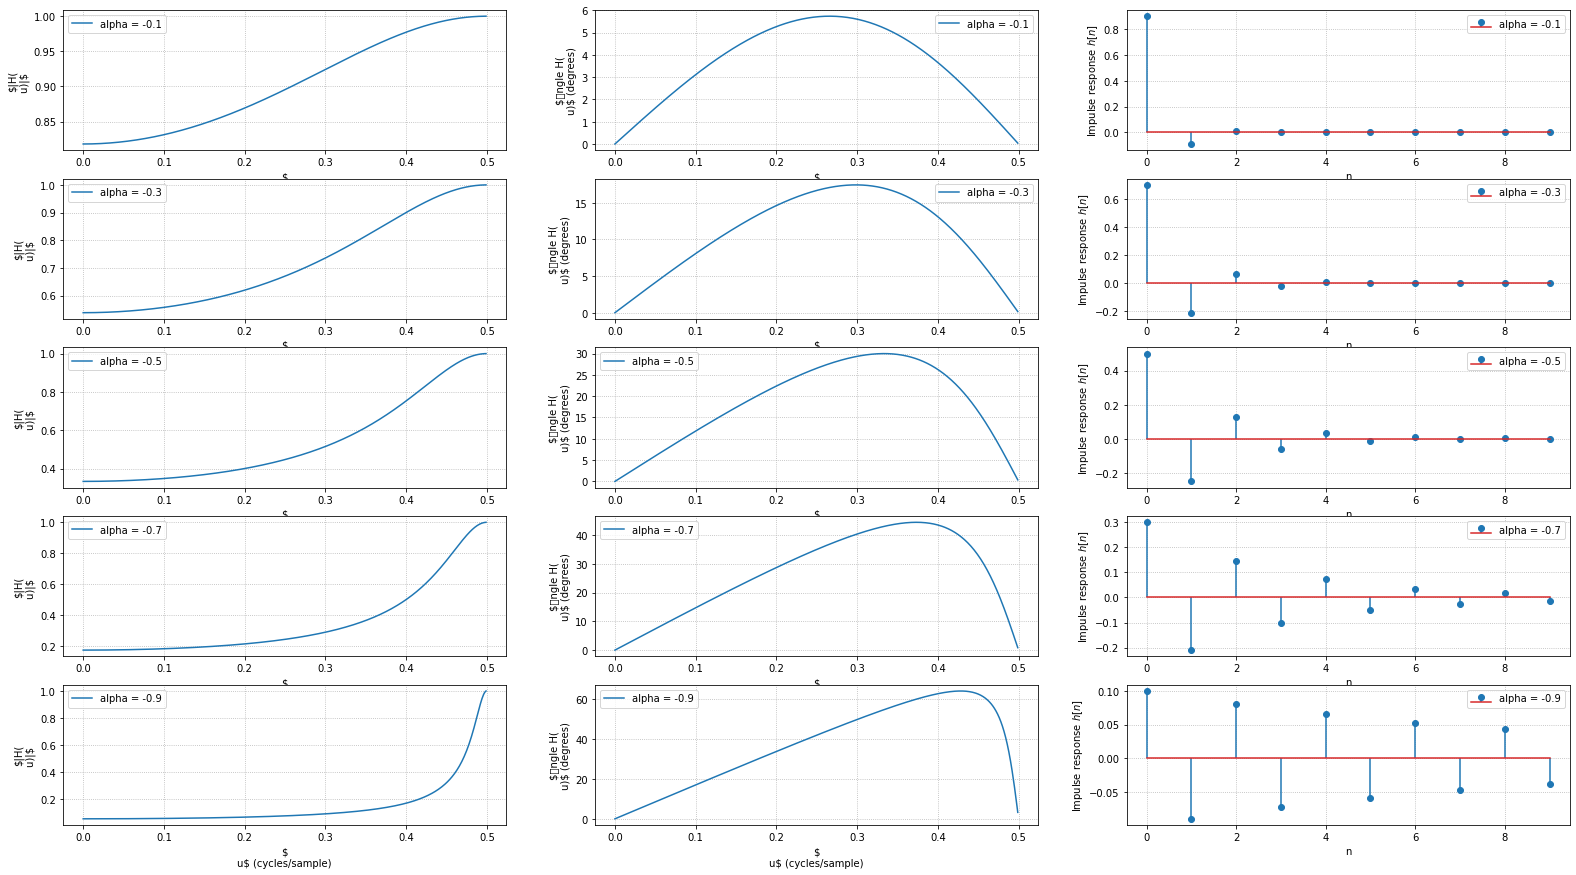

In [3]:
#### Set the parameters for the plots
## set HPF true to plot for negative alpha
HPF = True
## set use_db true to plot |H| in dB
use_db = False
## set normalize_gain true to make the passband-gain 1
normalize_gain = True


alphas = np.asarray([0.1, 0.3, 0.5, 0.7, 0.9])
v = np.arange(0, 0.5, 0.001)
n_time = np.arange(10)

if HPF:
    alphas *= -1

db_tag = ''

N_rows = len(alphas)
fig, ax = plt.subplots(N_rows, 3, figsize=(27, N_rows * 3))

for i, alpha in enumerate(alphas):
    H = H_AR1(v, alpha, normalize_gain=normalize_gain)
    h = alpha ** n_time
    if normalize_gain:
        h *= (1 - np.abs(alpha))
    H_mag = np.abs(H)
    if use_db:
        H_mag = 10 * np.log10(H_mag)
        db_tag = '(dB)'
    ax[i][0].plot(v, H_mag, label=f'alpha = {alpha}')
    ax[i][1].plot(v, np.unwrap(np.angle(H)) * (180 / np.pi), label=f'alpha = {alpha}')
    ax[i][2].stem(n_time, h, label=f'alpha = {alpha}')

    ax[i][0].set_xlabel('$\nu$ (cycles/sample)')
    ax[i][1].set_xlabel('$\nu$ (cycles/sample)')
    ax[i][2].set_xlabel('n')

    ax[i][0].set_ylabel(f'$|H(\nu)|$ {db_tag}')
    ax[i][1].set_ylabel(f'$\angle H(\nu)$ (degrees)')
    ax[i][2].set_ylabel('Impulse response $h[n]$')

    for j in range(3):
        ax[i][j].legend()
        ax[i][j].grid(linestyle=':')


### Let's look at an ideal LPF

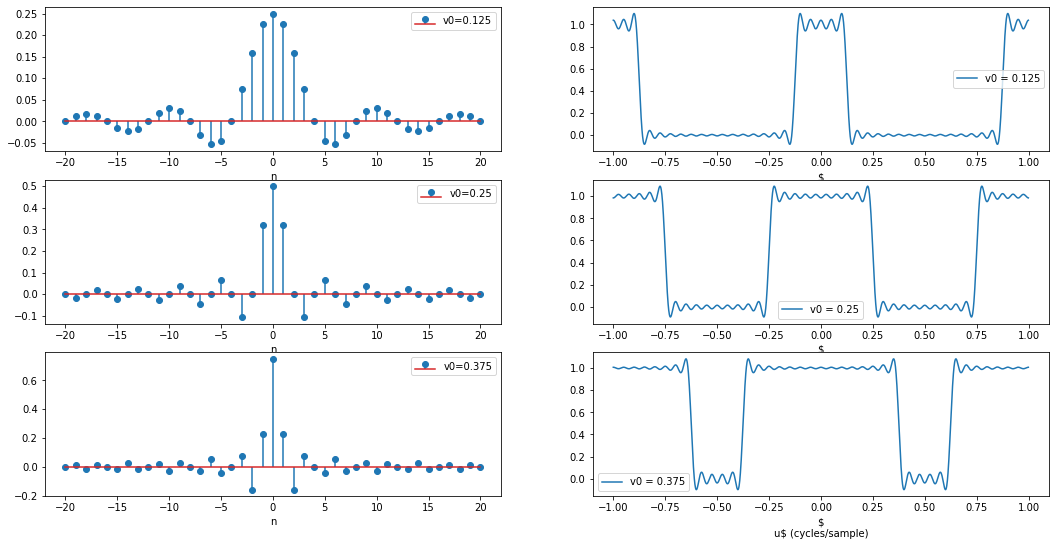

In [10]:
HPF = False

cut_off_freqs = np.asarray([1/8, 1/4, 3/8])
v = np.arange(-1, +1, 0.001)

M = 20
L = 2 * M + 1 

N_rows = len(cut_off_freqs)
fig, ax = plt.subplots(N_rows, 2, figsize=(18, N_rows * 3))
# fig, ax = plt.subplots(, 2, figsize=(18, 10))

for k, v0 in enumerate(cut_off_freqs):
    n_time = np.arange(L) - M
    h = 2 * v0 * np.sinc( 2 * v0 * n_time)
    if HPF:
        sign_flips = (-1.0) ** n_time
        h *= sign_flips
    ax[k][0].stem(n_time, h, label=f'v0={v0}')
    ax[k][0].legend()
    ax[k][0].set_xlabel('n')

    H = np.ones(len(v)) * h[M]
    for n in range(1, M+ 1):
        H += 2 * h[n + M] * np.cos(2 * np.pi * n * v)
    ax[k][1].plot(v, H, label=f'v0 = {v0}')
    ax[k][1].set_xlabel('$\nu$ (cycles/sample)')
    ax[k][1].legend()
    

## Next, let's look at the DTFT of a discrete time rect signal -- note that this is essentially the dual of the Fourier Series for a delta-train!  Often times, we multiply by a rect-window in the time domain, so the diric fucntion gets convolved (circular convolution) with the spectrum of the signal that gets windowed.

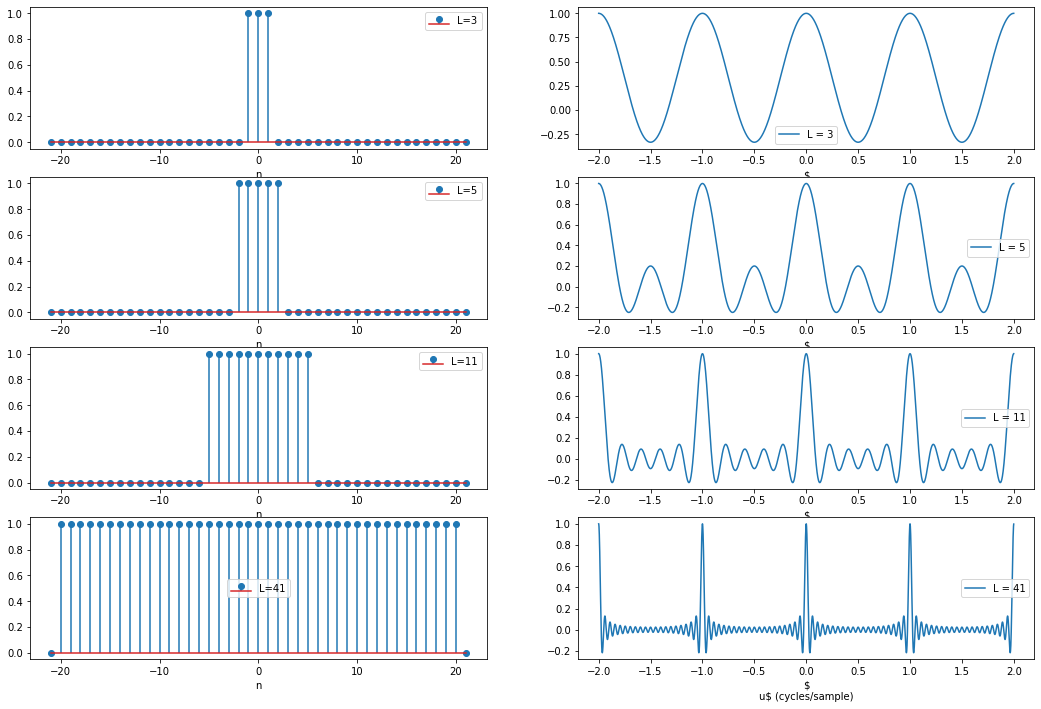

In [63]:

## Three different ways to compute the Dirichelet (diric) or "dinc" function. 
# Matlab has diric built in which is nice since, like the sinc, it has 0/0 behaivor at integer value of nu.
def diric_by_cos_sum(v, M):
    diric = np.ones(len(v))
    for m in range(1, M + 1):
        diric += 2 * np.cos(2 * np.pi * m * v)
    return diric / (2 * M +1)

def diric(v, L):
    return np.sinc(L * v)/np.sinc(v)

def dinc(v, M):
    L = 2 * M + 1
    return np.sin(np.pi * L * v)/( L * np.sin(np.pi * v) )

### you can verify these are all the same:
# plt.plot(v, diric(v, 7))
# plt.plot(v, dinc(v, 3))
# plt.plot(v, diric_by_cos_sum(v, 3))

M_vals = np.asarray([1, 2, 5, 20])
v = np.arange(0.0001 - 2, 2, 0.001)

N_rows = len(M_vals)
fig, ax = plt.subplots(N_rows, 2, figsize=(18, N_rows * 3))

M_max = np.max(M_vals)
L_max = 2 * M_max + 1
for k, M in enumerate(M_vals):
    L = 2 * M +1 

    n_time = np.arange(L_max + 2) - (M_max + 1)
    h = (np.abs(n_time) <= M).astype(np.float)
    ax[k][0].stem(n_time, h, label=f'L={L}')
    ax[k][0].legend()
    # ax[k][0].set_xlim([-1 * np.max(L_vals), np.max(L_vals)])

    ax[k][0].set_xlabel('n')

    ax[k][1].plot(v, diric(v, L), label=f'L = {L}')
    ax[k][1].set_xlabel('$\nu$ (cycles/sample)')
    ax[k][1].legend()



## Discrete Time Differentiator:

This can be used to implment a band-limited differentiator.  In this system, a continuous-time signal is sampled, the samples are then processed by this discrete-time filter, then the results are interpolated back to a CT signal.  

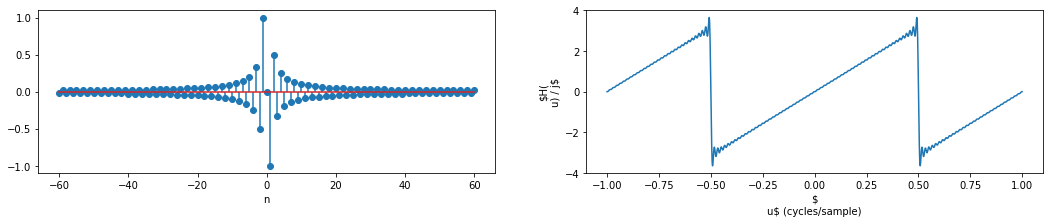

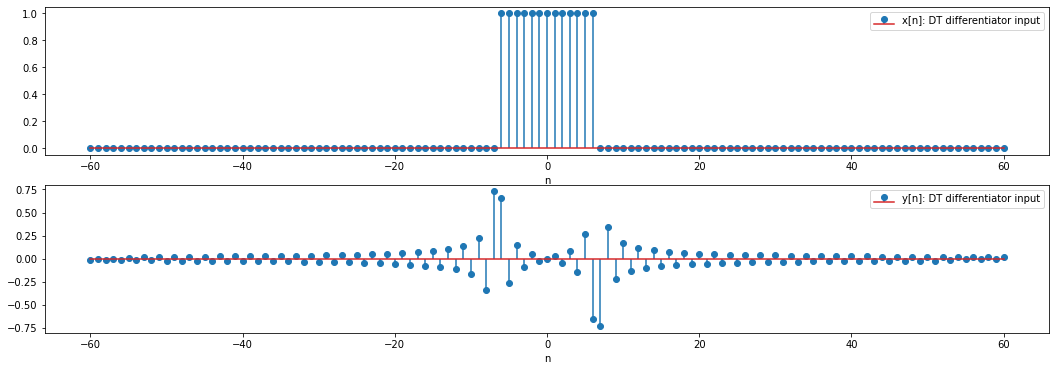

In [65]:
cut_off_freqs = np.asarray([1/8, 1/4, 3/8])
v = np.arange(-1, +1, 0.001)

M = 60
L = 2 * M + 1 

N_rows = 1
fig, ax = plt.subplots(N_rows, 2, figsize=(18, N_rows * 3))
# fig, ax = plt.subplots(, 2, figsize=(18, 10))

n_time = np.arange(L) - M
h = ((-1.0) ** n_time) / (n_time + 1e-20)
h[M] = 0

ax[0].stem(n_time, h)
ax[0].set_xlabel('n')



H_by_j = np.zeros(len(v))
for n in range(M + 1):
    ## Note: h[n] = - h[-n], so h[n] e^(-j 2pi v n) + h[-n] e^(j 2pi v n) = 2j sin(2 pi v n)
    H_by_j += -2 * h[n + M] * np.sin(2 * np.pi * n * v)  
ax[1].plot(v, H_by_j)
ax[1].set_xlabel('$\nu$ (cycles/sample)')
ax[1].set_ylabel('$H(\nu) / j$')

##### Try running a signal thru...
x = (np.abs(n_time) <= 6).astype(np.float)
y = np.convolve(h, x)

fig, ax = plt.subplots(2, figsize=(18, 6))
ax[0].stem(n_time, x, label='x[n]: DT differentiator input')
ax[1].stem(n_time, y[M:M+L], label='y[n]: DT differentiator input')
for i in range(2):
    ax[i].set_xlabel('n')
    ax[i].legend()



This doesn't seem like a great differentiator, but you have to consider that this is differentiating across the Nyquist band.  In other words, you have to think of these samples as interpolted to CT, then differentiated, and, fianlly, resampled.  Let's see what the interpolated signals at the input and output look like and see if this makes sense!

In [66]:
def sinc_terpolate(x_samples, Ts):
    N_samples = len(x_samples)
    t = np.arange(-3, N_samples + 3, Ts)
    x_hat = np.zeros(len(t))
    sinc_terms = np.zeros((N_samples, len(t)))
    for n in range(N_samples):
        sinc_terms[n] = x_samples[n] * np.sinc(t - n)
        x_hat += sinc_terms[n]
    return x_hat


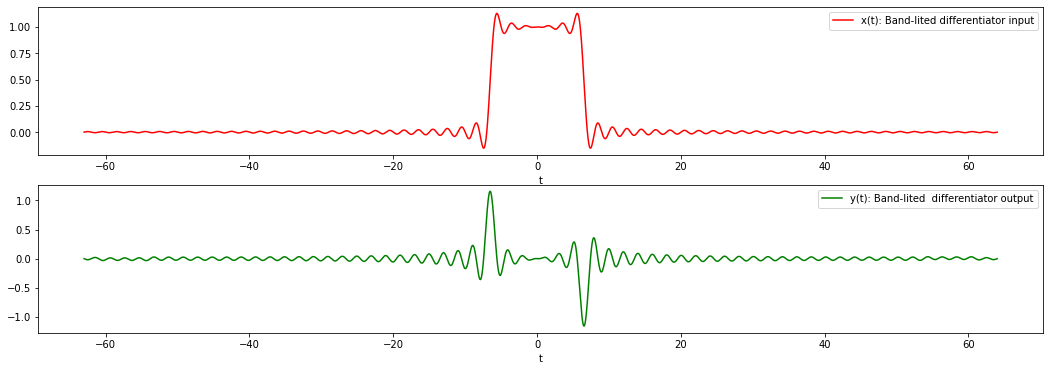

In [67]:
## x, y are in the input and output DT signals from the above code
 
Ts = 0.001
x_ct = sinc_terpolate(x, Ts)
y_ct = sinc_terpolate(y[M:M+L], Ts)
t_x = np.arange(len(x_ct)) * Ts + n_time[0] - 3  ## the interpolate pads by 3 on eac
fig, ax = plt.subplots(2, sharex=False, figsize=(18, 6))
ax[0].plot(t_x, x_ct, color='r', label='x(t): Band-lited differentiator input')
ax[1].plot(t_x, y_ct, color='g', label='y(t): Band-lited  differentiator output')
for i in range(2):
    ax[i].set_xlabel('t')
    ax[i].legend()


In practice, the FIR filters considered above woul dneed to be shifted to the right to make them causal.  This will introduce a linear phase.  

Also, instead of windowing the infinite length impulse response with a rectangular wondow, we can consider other windows -- i.e., this corresponds to convolving with another impulse-like signal in the frequency domain in place of the Dirichet signal that results from rectangular windowing.

## Example Filtering of Audio Files:
Let's try a few LPFs and a differentiator on our sample audio files...

In [73]:
M = 200
L = 2 * M + 1
n_time = np.arange(L) - M

h_diff = ((-1.0) ** n_time) / (n_time + 1e-20)
h_diff[M] = 0



filter_order = 8

for fname in ['data/chirp.wav', 'data/chugg_welcome.wav']:
    audio_in, fs = sf.read(fname)
    # use LPF with cut-off 2 kHz -- this is 0.0412 for fs = 48 KHz
    v0 = 2000 / fs
    
    h_fir = 2 * v0 * np.sinc( 2 * v0 * n_time)
    y_fir = np.convolve(audio_in, h_fir)
    out_fname = fname.replace('.wav', '_fir_2000.wav')
    sf.write(out_fname, y_fir, fs)

    b, a = signal.butter(filter_order, 2 * v0)  # signal.butter - specify the cut-off on [0,1], where 1 is nu = 0.5
    y_butter = signal.lfilter(b, a, audio_in)
    out_fname = fname.replace('.wav', f'_butter_{filter_order}_2000.wav')
    sf.write(out_fname, y_butter, fs)

    y_diff = np.convolve(audio_in, h_diff)
    out_fname = fname.replace('.wav', '_diff.wav')
    sf.write(out_fname, y_diff, fs)


    

The normalized cut-off frequency is pretty low -- i.e., $\nu_0 = 2/ 48 = 0.042$, so the FIR impulse response will be quite long.

<StemContainer object of 3 artists>

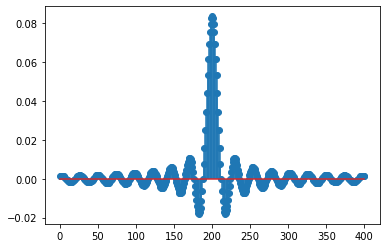

In [70]:
plt.stem(h_fir)

Let's plot the magnitude of teh 2 LPFs is a more traditional manner -- i.e., the magnitude in dB and plotting on $\nu in [0, 0.5]$.  We only plot this range of $\nu$ typically because the frequency response is Hermitian symmetric and periodic with period 1.  This means, we typically plot for $f = \nu F_s$ in $[0, F_s/2]$.

In fact, the interesting range is for frequencies below 5 kHz -- you can comment out the `xlim` command and see more if you like.

Text(0, 0.5, 'filter gain (dB)')

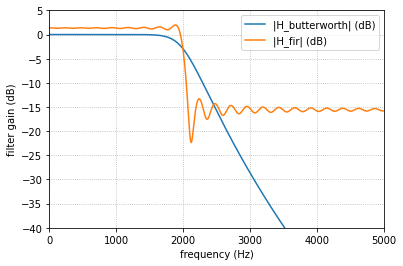

In [74]:
w, H_butter = signal.freqz(b, a, worN=2**16)
nu =  ( w / ( 2 * np.pi ) ) 

H_fir = np.ones(len(nu)) * h_fir[M]
for n in range(M+ 1):
    H_fir += 2 * h_fir[n + M] * np.cos(2 * np.pi * n * nu)

plt.figure()
plt.plot(nu * fs, 20 * np.log10(abs(H_butter)), label='|H_butterworth| (dB)')
plt.plot(nu * fs, 20 * np.log10(abs(H_fir)), label='|H_fir| (dB)')
plt.legend()
plt.grid(linestyle=':')
plt.xlim(0, 5000)
plt.ylim([-40, 5])
plt.xlabel(f'frequency (Hz)')
plt.ylabel('filter gain (dB)')

(-0.35, 0.35)

/Users/kmchugg/.pyenv/versions/ee301/lib/python3.8/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


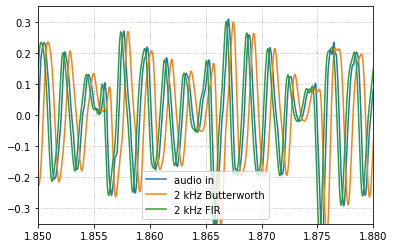

In [52]:
t_x = np.arange(len(audio_in)) / fs
t_butter = np.arange(len(y_butter)) / fs
t_fir = np.arange(len(y_fir)) / fs

t_start = 1.85
plt.figure()
plt.plot(t_x, audio_in, label='audio in')
plt.plot(t_butter, y_butter, label='2 kHz Butterworth')
# the FIR filter delay is M, but I am shifting by another 10 samples so we can see it
plt.plot(t_fir, np.roll(y_fir, -M - 10), label='2 kHz FIR') 
plt.legend()
plt.grid(linestyle=':')
plt.xlim([t_start, t_start + 0.03])
plt.ylim([-0.35, 0.35])




### Summary: note that running the Butterworth filter is much less complex.  Speciically, to process one sample, it requires one dot product of size 6 (order of the filter) while the FIR filter is doing a dot product of size equal to the lengther of the impulse repsonse which is much larger.  The FIR filter exhbits ripple in the passband and the stopband is limited.  The Butterworth filter, on the other hand, has non-ideal (nonlinear) phase reponse and has a larger transition from passband to stopband.  

(-0.35, 0.35)

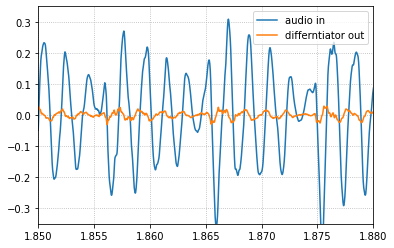

In [54]:

t_x = np.arange(len(audio_in)) / fs
t_diff = np.arange(len(y_diff)) / fs

t_start = 1.85
plt.figure()
plt.plot(t_x, audio_in, label='audio in')
# the FIR filter delay is M
plt.plot(t_fir, np.roll(y_diff, -M), label='differntiator out') 
plt.legend()
plt.grid(linestyle=':')
plt.xlim([t_start, t_start + 0.03])
plt.ylim([-0.35, 0.35])

